<a href="https://colab.research.google.com/github/adc257/info4940-sitcom/blob/main/0nContext_LLAMA_BASELINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install accelerate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
from google.colab import userdata
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
import torch
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from copy import deepcopy
import random
import json
import math
import os

In [3]:
!git clone https://github.com/adc257/info4940-sitcom.git

from google.colab import drive
drive.mount('/content/drive')

Cloning into 'info4940-sitcom'...
remote: Enumerating objects: 1133, done.
remote: Counting objects: 100% (1133/1133), done.
remote: Compressing objects: 100% (213/213), done.
remote: Total 1133 (delta 978), reused 1046 (delta 917), pack-reused 0
Receiving objects: 100% (1133/1133), 14.84 MiB | 13.08 MiB/s, done.
Resolving deltas: 100% (978/978), done.
Mounted at /content/drive


# Defining some helper functions

In [4]:
def list_files(start_path):
    file_paths = []
    for root, dirs, files in os.walk(start_path):
        for file in files:
            file_paths.append(os.path.join(root, file))

    file_paths.sort()
    return file_paths

def fPathList_TO_DialogueWithContext(filePathList, nSentenceContext):
  humorous_inputs = []
  non_humorous_inputs = []

  # formatted_inputs = []
  # labels = []

  for episodePath in filePathList:

    with open(episodePath, 'r') as file:
      data = json.load(file)
      data = [info for (_, info) in data.items()]


      i = nSentenceContext
      while i < len(data):
        context = [data[j] for j in range(i-nSentenceContext, i)]
        target = data[i]

        if 'isHumor' in target:
          humorous_inputs.append(transformInput(context, target))
        else:
          non_humorous_inputs.append(transformInput(context, target))

        i += 1

  return humorous_inputs, non_humorous_inputs

def sampleEven(positiveData, negativeData, sample_size_per_class, rand_seed):
  sample_size_per_class = min(sample_size_per_class, len(humorousData), len(nonHumorousData))

  sample_inputs = []
  sample_labels = []

  data = positiveData
  test_size = (len(data) - sample_size_per_class) / len(data)
  sample, _ = train_test_split(data, test_size=test_size, random_state=rand_seed)
  sample_inputs += sample
  sample_labels += [1]*len(sample)


  data = negativeData
  test_size = (len(data) - sample_size_per_class) / len(data)
  sample, _ = train_test_split(data, test_size=test_size, random_state=rand_seed)
  sample_inputs += sample
  sample_labels += [0]*len(sample)

  return sample_inputs, sample_labels

def createBatches(data, batch_size):
  return [data[i:i+batch_size] for i in range(0, len(data), batch_size)]

def testLLAMA(inputs, labels, printResultsEveryN=50):
  resultsData = {
      "truePos": [],
      "trueNeg": [],
      "falsePos": [],
      "falseNeg": [],
  }

  results = {
      "truePos": 0,
      "trueNeg": 0,
      "falsePos": 0,
      "falseNeg": 0,
  }

  correct = 0
  total = 0
  pred = []

  terminators = [
      tokenizer.eos_token_id,
      tokenizer.convert_tokens_to_ids("<|eot_id|>")
  ]

  for i in range(len(inputs)):
    input = inputs[i]
    label = labels[i]

    input_ids = tokenizer.apply_chat_template(
      input,
      add_generation_prompt=True,
      return_tensors="pt"
    ).to(model.device)

    outputs = model.generate(
      input_ids,
      max_new_tokens=50,
      eos_token_id=terminators,
      do_sample=True,
      temperature=0.6,
      top_p=0.9,
      num_return_sequences=1,
    )

    response = outputs[0][input_ids.shape[-1]:]
    response = tokenizer.decode(response, skip_special_tokens=True)
    modelInput = tokenizer.decode(input_ids[0], skip_special_tokens=False)

    resultsDict = {
        "input": modelInput,
        "output": response,
    }


    if str(response) == str(label):
      # true
      if str(label) == "1":
        # pos
        resultsData["truePos"].append(resultsDict)
        results["truePos"] += 1
      else:
        # neg
        resultsData["trueNeg"].append(resultsDict)
        results["trueNeg"] += 1
      correct += 1
    else:
      # false
      if str(label) == "1":
        # pos, pred neg
        resultsData["falseNeg"].append(resultsDict)
        results["falseNeg"] += 1
      else:
        # neg, pred pos
        resultsData["falsePos"].append(resultsDict)
        results["falsePos"] += 1
    pred.append(response)
    total += 1

    if i % printResultsEveryN == 0:
      print(f"Test: {i+1} of  {len(inputs)}")
      print(f"Success rate: {correct / total:.2%}\n")
      print("results data:", results)


  print(f"Final success rate: {correct / total:.2%}")

  # true = [str(i) for i in labels]
  # report = classification_report(y_pred=pred, y_true=true, target_names=["Non-Humorous","Humorous"])
  report = None

  return results, resultsData, pred, report

In [5]:
def testLLAMAScaleOutput(inputs, labels, scale, printResultsEveryN=50):
  # resultsData = {
  #     "truePos": [],
  #     "trueNeg": [],
  #     "falsePos": [],
  #     "falseNeg": [],
  # }

  # results = {
  #     "truePos": 0,
  #     "trueNeg": 0,
  #     "falsePos": 0,
  #     "falseNeg": 0,
  # }

  # blankResultsData = {str(i): [] for i in range(scale[0], scale[1]+1)}

  resultsData = {
      "truePos": {str(i): [] for i in range(scale[0], scale[1]+1)},
      "trueNeg": {str(i): [] for i in range(scale[0], scale[1]+1)},
      "other": []
  }

  # blankResults = {str(i): 0 for i in range(scale[0], scale[1]+1)}

  results = {
      "truePos": {str(i): 0 for i in range(scale[0], scale[1]+1)},
      "trueNeg": {str(i): 0 for i in range(scale[0], scale[1]+1)},
      "other": 0
  }

  correct = 0
  total = 0
  pred = []

  terminators = [
      tokenizer.eos_token_id,
      tokenizer.convert_tokens_to_ids("<|eot_id|>")
  ]

  for i in range(len(inputs)):
    input = inputs[i]
    label = labels[i]

    input_ids = tokenizer.apply_chat_template(
      input,
      add_generation_prompt=True,
      return_tensors="pt"
    ).to(model.device)

    outputs = model.generate(
      input_ids,
      max_new_tokens=50,
      eos_token_id=terminators,
      do_sample=True,
      temperature=0.6,
      top_p=0.9,
      num_return_sequences=1,
    )

    response = outputs[0][input_ids.shape[-1]:]
    response = tokenizer.decode(response, skip_special_tokens=True)
    modelInput = tokenizer.decode(input_ids[0], skip_special_tokens=False)

    resultsDict = {
        "input": modelInput,
        "output": response,
    }

    responseInt = str(response)

    if not responseInt.isdigit():
      resultsData["other"].append(resultsDict)
      results["other"] += 1
    else:
      if str(label) == "1":
        resultsData["truePos"][responseInt].append(resultsDict)
        results["truePos"][responseInt] += 1
      elif str(label) == "0":
        resultsData["trueNeg"][responseInt].append(resultsDict)
        results["trueNeg"][responseInt] += 1
      else:
        resultsData["other"].append(resultsDict)
        results["other"] += 1

    pred.append(response)
    total += 1

    if i % printResultsEveryN == 0:
      print(f"Test: {i+1} of  {len(inputs)}")
      # print(f"Success rate: {correct / total:.2%}\n")
      print("results data:", results)


  # print(f"Final success rate: {correct / total:.2%}")
  print(f"Final results", results)

  # true = [str(i) for i in labels]
  # report = classification_report(y_pred=pred, y_true=true, target_names=["Non-Humorous","Humorous"])
  report = None

  return results, resultsData, pred, report

## Defining input formatters

In [6]:
def transformInput(context, target):
  # if not context:
  #   return transformInputNoContext(target)

  messages = []

  separator = "\n"
  quotation_token = '"'

  # formatted_input = ""

  systemPrmpt = {
      'role': 'system',
      'content': ""
  }

  if len(context) > 0:
    systemPrmpt['content'] += "You are humor classification model, determine whether the target dialogue is humorous using the previous dialogue as context. RESTRICTION: ONLY RESPOND 1 (for humorous) OR 0 (for not humorous)."
  else:
    systemPrmpt['content'] += "You are humor classification model, determine whether the target dialogue is humorous. RESTRICTION: ONLY RESPOND 1 (for humorous) OR 0 (for not humorous)."

  # append systemPrmpt
  messages.append(systemPrmpt)

  # systemPrmpt2 = {
  #     'role': 'system',
  #     'content': ""
  # }
  userPrmpt = {
      'role': 'user',
      'content': ""
  }
  # userPrmpt2 = {
  #     'role': 'user',
  #     'content': ""
  # }
  # asstPrmpt = {
  #     'role': 'assistant',
  #     'content': ""
  # }


  if len(context) > 0:
    # CONTEXT
    userPrmpt['content'] += "Context:" + separator

    # if entry['Scene'] != current_scene:
    #   current_scene = entry["Scene"]
    #   userPrmpt2['content'] += "The scene changes to: "
    # else:
    #   userPrmpt2['content'] += "The Scene is still: "

    # userPrmpt2['content'] += current_scene + separator

    for entry in context:
      # if current_scene != entry['Scene']:
      #   current_scene = entry["Scene"]
      #   userPrmpt2['content'] += "The scene changes to: " + current_scene + separator

      recipients = entry['Recipients']
      recipients = [i for i in recipients if i != ""]

      recipients_str = ""
      if len(recipients) == 0:
        recipients_str += "to themselves"
      elif len(recipients) == 1:
        recipients_str += recipients[0]
      else:
        recipients_str += ", ".join(recipients[:-1]) + " and " + recipients[-1]

      userPrmpt['content'] += f"{entry['Speaker']} says {quotation_token}{entry['Dialogue']}{quotation_token} to {recipients_str}." + separator

  # TARGET LINE
  userPrmpt['content'] += separator + "Target:" + separator

  # current_scene = context[0]['Scene']
  # userPrmpt['content'] += "Is the following target_moment from the sitcom, the Big Bang Theory, humorous or not humorous? Only respond '1' for humorous or '0' for not humorous:"
  # userPrmpt['content'] += separator*2

  entry = target

  # if entry['Scene'] != current_scene:
  #   current_scene = entry["Scene"]
  #   userPrmpt['content'] += "The scene changes to: "
  # else:
  #   userPrmpt['content'] += "The Scene is still: "
  # userPrmpt['content'] += current_scene + separator

  recipients = entry['Recipients']
  recipients = [i for i in recipients if i != ""]
  recipients_str = ""
  if len(recipients) == 0:
    recipients_str += "to themselves"
  elif len(recipients) == 1:
    recipients_str += recipients[0]
  else:
    recipients_str += ", ".join(recipients[:-1]) + " and " + recipients[-1]


  userPrmpt['content'] += f"{entry['Speaker']} says {quotation_token}{entry['Dialogue']}{quotation_token} to {recipients_str}." + separator

  # userPrmpt['content'] += separator*2 + "Is the target dialogue humorous (return 1) or not humorous (return 0)?"
  userPrmpt['content'] += separator*2 + "Rate the target dialogue on a scale of 1 (not humorous) to 5 (humorous)."

  # systemPrmpt2['content'] += "Using the context provided, return '1' if the target_moment was humorous or '0' if the target_moment was not humorous?"
  # append userPrmpt
  messages.append(userPrmpt)

  # asstPrmpt['content'] += "Can you provide some context to help me with this decision?"
  # append asstPrmpt
  # messages.append(asstPrmpt)

  # userPrmpt['content'] += "Context:" + separator

  # if entry['Scene'] != current_scene:
  #   current_scene = entry["Scene"]
  #   userPrmpt2['content'] += "The scene changes to: "
  # else:
  #   userPrmpt2['content'] += "The Scene is still: "

  # userPrmpt2['content'] += current_scene + separator

  # for entry in context:
  #   if current_scene != entry['Scene']:
  #     current_scene = entry["Scene"]
  #     userPrmpt2['content'] += "The scene changes to: " + current_scene + separator

  #   recipients = entry['Recipients']
  #   recipients = [i for i in recipients if i != ""]

  #   recipients_str = ""
  #   if len(recipients) == 0:
  #     recipients_str += "to themselves"
  #   elif len(recipients) == 1:
  #     recipients_str += recipients[0]
  #   else:
  #     recipients_str += ", ".join(recipients[:-1]) + " and " + recipients[-1]

  #   userPrmpt2['content'] += f"{entry['Speaker']} says {quotation_token}{entry['Dialogue']}{quotation_token} to {recipients_str}."
  #   userPrmpt2['content'] += separator

  # # append userPrmpt2
  # messages.append(userPrmpt2)

  # userPrmpt2['content'] += separator + "-" *20 + separator*2

  # systemPrmpt2['content'] += "Using the context provided, return '1' if the target_moment was humorous or '0' if the target_moment was not humorous?"

  # append systemPrmpt2
  # messages.append(systemPrmpt2)

  # messages = [systemPrmpt, userPrmpt, asstPrmpt, ]

  return messages

In [7]:
def transformInputNoContext(target):
  messages = []

  separator = "\n"
  quotation_token = '"'

  # formatted_input = ""

  systemPrmpt = {
      'role': 'system',
      'content': "You are humor classification model that takes a given line (the target), and determines whether the target line was humorous (return '1') or not humorous (return '0'). RESTRICTION: ONLY RESPOND 1 OR 0."
  }
  # append systemPrmpt
  messages.append(systemPrmpt)

  systemPrmpt2 = {
      'role': 'system',
      'content': ""
  }
  userPrmpt = {
      'role': 'user',
      'content': ""
  }
  userPrmpt2 = {
      'role': 'user',
      'content': ""
  }
  asstPrmpt = {
      'role': 'assistant',
      'content': ""
  }

  # current_scene = context[0]['Scene']

  userPrmpt['content'] += "Is the following moment from the sitcom, the Big Bang Theory, humorous or not humorous? Only respond '1' for humorous or '0' for not humorous:"
  userPrmpt['content'] += separator*2
  entry = target
  userPrmpt['content'] += "The Scene is: " + entry['Scene'] + separator


  recipients = entry['Recipients']
  recipients_str = ""
  if len(recipients) == 0:
    recipients_str += "to themselves"
  elif len(recipients) == 1:
    recipients_str += recipients[0]
  else:
    recipients_str += ", ".join(recipients[:-1]) + " and " + recipients[-1]

  userPrmpt['content'] += f"{entry['Speaker']} says {quotation_token}{entry['Dialogue']}{quotation_token} to {recipients_str}."



  # append userPrmpt
  messages.append(userPrmpt)

  # asstPrmpt['content'] += "Can you provide some context to help me with this decision?"
  # # append asstPrmpt
  # messages.append(asstPrmpt)

  # userPrmpt2['content'] += "Yes, use the following as context:" + separator*2

  # if entry['Scene'] != current_scene:
  #   current_scene = entry["Scene"]
  #   userPrmpt2['content'] += "The scene changes to: "
  # else:
  #   userPrmpt2['content'] += "The Scene is still: "

  # userPrmpt2['content'] += current_scene + separator

  # for entry in context:
  #   if current_scene != entry['Scene']:
  #     current_scene = entry["Scene"]
  #     userPrmpt2['content'] += "The scene changes to: " + current_scene + separator

  #   recipients = entry['Recipients']
  #   recipients_str = ""
  #   if len(recipients) == 0:
  #     recipients_str += "to themselves"
  #   elif len(recipients) == 1:
  #     recipients_str += recipients[0]
  #   else:
  #     recipients_str += ", ".join(recipients[:-1]) + " and " + recipients[-1]

  #   userPrmpt2['content'] += f"{entry['Speaker']} says {quotation_token}{entry['Dialogue']}{quotation_token} to {recipients_str}."
  #   userPrmpt2['content'] += separator

  # # append userPrmpt2
  # messages.append(userPrmpt2)

  # userPrmpt2['content'] += separator + "-" *20 + separator*2

  # systemPrmpt2['content'] += "Using the context provided, return '1' if the target_moment was humorous or '0' if the target_moment was not humorous?"

  # append systemPrmpt2
  # messages.append(systemPrmpt2)

  # messages = [systemPrmpt, userPrmpt, asstPrmpt, ]

  return messages

### Some nShot specific formatters

In [8]:
def fPathList_TO_ContextsTargetsLabels(filePathList, nSentenceContext):
  humorEntries = []
  nonHumorEntries = []

  for episodePath in filePathList:
    with open(episodePath, 'r') as file:
      data = json.load(file)
      data = [info for (_, info) in data.items()]


      i = nSentenceContext
      while i < len(data):
        entry = {}

        entry['context'] = [data[j] for j in range(i-nSentenceContext, i)]
        entry['target'] = data[i]
        if 'isHumor' in data[i]:
          entry['label'] = 1
          humorEntries.append(entry)
        else:
          entry['label'] = 0
          nonHumorEntries.append(entry)
        i += 1

  return humorEntries, nonHumorEntries

def transformInputNShot(entries, labels):
  # if (len(contexts) != len(targets)) & (len(contexts) != len(labels)):
  #   print("TRANSFORMINPUT nSHOT ERROR, CONTEXTS, TARGETS, LABELS NOT EQUAL LENGTHS")
  #   return

  # if not context:
  #   return transformInputNoContext(target)


  separator = "\n"
  quotation_token = '"'

  formatted_input = "Here are some examples of the task:\n"

  for i in range(len(entries)):
    context = entries[i]['context']
    target = entries[i]['target']
    label = labels[i]

    current_scene = context[-1]['Scene']

    formatted_input += separator*2 + f"Example {i + 1}:" + separator

    # formatted_input += "User: Is the following target_moment from the sitcom, the Big Bang Theory, humorous or not humorous? Only respond '1' for humorous or '0' for not humorous:"

    formatted_input += "Target moment:" + separator

    entry = target
    if entry['Scene'] != current_scene:
      current_scene = entry["Scene"]
      formatted_input += "The scene changes to: "
    else:
      formatted_input += "The Scene is still: "

    formatted_input += current_scene + separator


    recipients = entry['Recipients']
    recipients = [i for i in recipients if i != ""]

    recipients_str = ""
    if len(recipients) == 0:
      recipients_str += "to themselves"
    elif len(recipients) == 1:
      recipients_str += recipients[0]
    else:
      recipients_str += ", ".join(recipients[:-1]) + " and " + recipients[-1]

    formatted_input += f"{entry['Speaker']} says {quotation_token}{entry['Dialogue']}{quotation_token} to {recipients_str}." + separator

    # formatted_input += "Assistant: Can you provide some context to help me with this decision?" + separator

    # formatted_input += "User: Yes, use the following as context:" + separator*2

    formatted_input += "-"*20 + separator + "Context:" + separator

    if entry['Scene'] != current_scene:
      current_scene = entry["Scene"]
      formatted_input += "The scene changes to: "
    else:
      formatted_input += "The Scene is still: "

    formatted_input += current_scene + separator

    for entry in context:
      if current_scene != entry['Scene']:
        current_scene = entry["Scene"]
        formatted_input += "The scene changes to: " + current_scene + separator

      recipients = entry['Recipients']
      recipients = [i for i in recipients if i != ""]
      recipients_str = ""
      if len(recipients) == 0:
        recipients_str += "to themselves"
      elif len(recipients) == 1:
        recipients_str += recipients[0]
      else:
        recipients_str += ", ".join(recipients[:-1]) + " and " + recipients[-1]

      formatted_input += f"{entry['Speaker']} says {quotation_token}{entry['Dialogue']}{quotation_token} to {recipients_str}." + separator

    formatted_input += "-"*20 + separator
    formatted_input += f"Correct Output: {label}"

  return formatted_input

def addNShotText(input, nShotText):
  returnInput = deepcopy(input)

  if input[0]['role'] != "system":
    print("ERROR: first message in input is not assigned")
    return

  returnInput[0]['content'] += "\n\n" + nShotText

  return returnInput

# Creating sample data

In [9]:
filePaths = []
for i in range(5):
  fPath = '/content/info4940-sitcom/cleaned-data/S' + str(i+1)
  filePaths += list_files(fPath)

# getting random number for random state for consistency?
rand_seed1 = 64 # random.randint(1,100)
rand_seed2 = 94 # random.randint(1,100)
rand_seed3 = 69 # random.randint(1,100)
rand_seed4 = 74 # random.randint(1,100)


# print([rand_seed1,rand_seed2,rand_seed3])

# sampling 10 episodes
nSamples = 10
test_size = (len(filePaths) - nSamples) / len(filePaths)
samplePaths, nShotSamplePaths = train_test_split(filePaths, test_size=test_size, random_state=rand_seed1)

# cleaning/transforming inputs
nContext = 0
humorousData, nonHumorousData = fPathList_TO_DialogueWithContext(samplePaths, nContext)
sample_inputs, sample_labels = sampleEven(positiveData=humorousData, negativeData=nonHumorousData, sample_size_per_class=250, rand_seed=rand_seed2)

# shuffling, not necessary but helpful for watching in-progress results
rand_order = [i for i in range(len(sample_inputs))]
random.seed(rand_seed3)
random.shuffle(rand_order)
random.seed(random.randint(1,100))

inputs = [sample_inputs[i] for i in rand_order]
labels = [sample_labels[i] for i in rand_order]

## Creating nShotText

In [ ]:
nShot = 16

random.shuffle(nShotSamplePaths)
nShotSamplePaths = nShotSamplePaths[:3]

nShotHumorEntries, nShotNonHumorEntries = fPathList_TO_ContextsTargetsLabels(nShotSamplePaths, nContext)
nShot_sample_entries, nShot_sample_labels = sampleEven(positiveData=nShotHumorEntries, negativeData=nShotNonHumorEntries, sample_size_per_class=math.ceil(nShot/2), rand_seed=rand_seed4)

rand_order = [i for i in range(len(nShot_sample_entries))]
random.shuffle(rand_order)

nShot_sample_entries = [nShot_sample_entries[i] for i in rand_order]
nShot_sample_labels = [nShot_sample_labels[i] for i in rand_order]


nShotText = transformInputNShot(entries=nShot_sample_entries, labels=nShot_sample_labels)
# inputs = [addNShotText(input, nShotText) for input in inputs]


### Sample nShot Text

In [ ]:
# nShot_sample_entries

In [ ]:
# print(nShotText)

## Sample Raw and Cleaned Formats:

In [12]:
filePath = "/content/info4940-sitcom/cleaned-data/S1/The Big Bang_S0101.json"
nSentenceContext = nContext

with open(filePath, 'r') as file:
  data = json.load(file)
  data = [info for (_, info) in data.items()]

print(f"Example raw entry:")
display(data[3])

print(f"\n\nExample formatted entry ({nSentenceContext}context) (0-shot):\n")
input = transformInput(context=data[:nSentenceContext], target=data[nSentenceContext])
for i in input:
  print(f"Role: {i['role']} | Content:\n{i['content']}\n")

print(f'Actual: {("isHumor" in data[3])}')


print(f"\n\nExample formatted entry ({nSentenceContext}context) (4-shot):\n")
input = transformInput(context=data[:nSentenceContext], target=data[nSentenceContext])
# input = addNShotText(input, nShotText)


# for i in input:
#   print(f"Role: {i['role']} | Content:\n{i['content']}\n")

# print(f'Actual: {("isHumor" in data[nScentenceContext])}')

Example raw entry:


{'EpisodeID': 'The Big Bang_S0101',
 'Scene': 'A corridor at a sperm bank.',
 'Recipients': ['Sheldon', 'Receptionist'],
 'Speaker': 'Leonard',
 'Dialogue': 'Excuse me.',
 'Dialogue Start Time': '00:00:23:140000',
 'Dialogue End Time': '00:00:25:060000'}



Example formatted entry (0context) (0-shot):

Role: system | Content:
You are humor classification model, determine whether the target dialogue is humorous. RESTRICTION: ONLY RESPOND 1 (for humorous) OR 0 (for not humorous).

Role: user | Content:

Target:
Sheldon says "So if a photon is directed through a plane with two slits in it and either slit is observed, it will not go through both slits. If it's unobserved, it will. However, if it's observed after it's left the plane but before it hits its target, it won't have gone through both slits." to Leonard.


Rate the target dialogue on a scale of 1 (not humorous) to 5 (humorous).

Actual: False


Example formatted entry (0context) (4-shot):



# The LLAMA 3 8B instruct model

In [13]:
!pip install bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 14.0 MB/s eta 0:00:00


In [14]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

In [ ]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id,
                                          token=userdata.get('HF_TOKEN'),
                                          low_cpu_mem_usage=True,
                                          quantization_config=quantization_config,
                                          )

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    token=userdata.get('HF_TOKEN')
)

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

In [ ]:
# Saves Model to Drive

model_path = '/content/drive/My Drive/INFO4940_humor/LLAMA3_8b_instruct_Quantized_4bit'

model.save_pretrained(model_path)

tokenizer_path = '/content/drive/My Drive/INFO4940_humor/LLAMA3_8b_instruct_Quantized_4bit_tokenizer'

tokenizer.save_pretrained(tokenizer_path)

In [15]:
# Loads Model from Drive

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id,
                                          token=userdata.get('HF_TOKEN'),
                                          low_cpu_mem_usage=True,
                                          quantization_config=quantization_config,
                                          )

model_path = '/content/drive/My Drive/INFO4940_humor/LLAMA3_8b_instruct_Quantized_4bit'
model = AutoModelForCausalLM.from_pretrained(model_path)

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

# Testing

In [16]:
terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]


input = inputs[0]
label = labels[0]


# syscont = 'You are humor classification model, determine whether the target dialogue is humorous using the previous dialogue as context. RESTRICTION: ONLY RESPOND INTEGERS 1 THRU 5, WHERE 1 MEANS NOT HUMOROUS AND 5 MEANS HUMOROUS.'
# input[0]['content'] = syscont

input_ids = tokenizer.apply_chat_template(
  input,
  add_generation_prompt=True,
  return_tensors="pt"
).to(model.device)

outputs = model.generate(
  input_ids,
  max_new_tokens=10,
  eos_token_id=terminators,
  do_sample=True,
  temperature=0.5,
  top_p=0.9,
  num_return_sequences=10,
)

response = outputs[0][input_ids.shape[-1]:]
response = tokenizer.decode(response, skip_special_tokens=True)

print(response)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


1


In [17]:

for i in range(len(outputs)):
  print(tokenizer.decode(outputs[i][input_ids.shape[-1]:], skip_special_tokens=True))

1
1
1
1
1
1
1
1
1
1


In [18]:
print(tokenizer.decode(input_ids[0], skip_special_tokens=False))


<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are humor classification model, determine whether the target dialogue is humorous. RESTRICTION: ONLY RESPOND 1 (for humorous) OR 0 (for not humorous).<|eot_id|><|start_header_id|>user<|end_header_id|>

Target:
Mrs Wolowitz says "She's a lovely girl! Cute as a button!" to Howard and MrsWolowitz.


Rate the target dialogue on a scale of 1 (not humorous) to 5 (humorous).<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [19]:
print(input)
print(f'expected: {label}, model: {response}')


for i in input:
  print(i['content'])

[{'role': 'system', 'content': 'You are humor classification model, determine whether the target dialogue is humorous. RESTRICTION: ONLY RESPOND 1 (for humorous) OR 0 (for not humorous).'}, {'role': 'user', 'content': '\nTarget:\nMrs Wolowitz says "She\'s a lovely girl! Cute as a button!" to Howard and MrsWolowitz.\n\n\nRate the target dialogue on a scale of 1 (not humorous) to 5 (humorous).'}]
expected: 0, model: 1
You are humor classification model, determine whether the target dialogue is humorous. RESTRICTION: ONLY RESPOND 1 (for humorous) OR 0 (for not humorous).

Target:
Mrs Wolowitz says "She's a lovely girl! Cute as a button!" to Howard and MrsWolowitz.


Rate the target dialogue on a scale of 1 (not humorous) to 5 (humorous).


In [20]:
results, resultsData, pred, report = testLLAMA(inputs, labels, printResultsEveryN=10)

# results, resultsData, pred, report = testLLAMAScaleOutput(inputs, labels, (1,5), printResultsEveryN=10)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Test: 1 of  500
Success rate: 0.00%

results data: {'truePos': 0, 'trueNeg': 0, 'falsePos': 1, 'falseNeg': 0}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 11 of  500
Success rate: 63.64%

results data: {'truePos': 7, 'trueNeg': 0, 'falsePos': 4, 'falseNeg': 0}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 21 of  500
Success rate: 47.62%

results data: {'truePos': 10, 'trueNeg': 0, 'falsePos': 11, 'falseNeg': 0}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 31 of  500
Success rate: 54.84%

results data: {'truePos': 16, 'trueNeg': 1, 'falsePos': 14, 'falseNeg': 0}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 41 of  500
Success rate: 48.78%

results data: {'truePos': 19, 'trueNeg': 1, 'falsePos': 21, 'falseNeg': 0}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 51 of  500
Success rate: 50.98%

results data: {'truePos': 24, 'trueNeg': 2, 'falsePos': 25, 'falseNeg': 0}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 61 of  500
Success rate: 50.82%

results data: {'truePos': 29, 'trueNeg': 2, 'falsePos': 30, 'falseNeg': 0}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 71 of  500
Success rate: 52.11%

results data: {'truePos': 35, 'trueNeg': 2, 'falsePos': 34, 'falseNeg': 0}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 81 of  500
Success rate: 55.56%

results data: {'truePos': 43, 'trueNeg': 2, 'falsePos': 36, 'falseNeg': 0}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 91 of  500
Success rate: 57.14%

results data: {'truePos': 49, 'trueNeg': 3, 'falsePos': 39, 'falseNeg': 0}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 101 of  500
Success rate: 55.45%

results data: {'truePos': 53, 'trueNeg': 3, 'falsePos': 45, 'falseNeg': 0}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 111 of  500
Success rate: 55.86%

results data: {'truePos': 59, 'trueNeg': 3, 'falsePos': 48, 'falseNeg': 1}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 121 of  500
Success rate: 56.20%

results data: {'truePos': 65, 'trueNeg': 3, 'falsePos': 52, 'falseNeg': 1}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 131 of  500
Success rate: 56.49%

results data: {'truePos': 71, 'trueNeg': 3, 'falsePos': 55, 'falseNeg': 2}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 141 of  500
Success rate: 55.32%

results data: {'truePos': 75, 'trueNeg': 3, 'falsePos': 61, 'falseNeg': 2}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 151 of  500
Success rate: 54.97%

results data: {'truePos': 80, 'trueNeg': 3, 'falsePos': 66, 'falseNeg': 2}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 161 of  500
Success rate: 53.42%

results data: {'truePos': 83, 'trueNeg': 3, 'falsePos': 73, 'falseNeg': 2}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 171 of  500
Success rate: 52.63%

results data: {'truePos': 86, 'trueNeg': 4, 'falsePos': 79, 'falseNeg': 2}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 181 of  500
Success rate: 51.93%

results data: {'truePos': 89, 'trueNeg': 5, 'falsePos': 85, 'falseNeg': 2}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 191 of  500
Success rate: 50.79%

results data: {'truePos': 92, 'trueNeg': 5, 'falsePos': 92, 'falseNeg': 2}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 201 of  500
Success rate: 51.24%

results data: {'truePos': 98, 'trueNeg': 5, 'falsePos': 96, 'falseNeg': 2}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 211 of  500
Success rate: 50.24%

results data: {'truePos': 100, 'trueNeg': 6, 'falsePos': 102, 'falseNeg': 3}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 221 of  500
Success rate: 49.77%

results data: {'truePos': 104, 'trueNeg': 6, 'falsePos': 108, 'falseNeg': 3}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 231 of  500
Success rate: 50.65%

results data: {'truePos': 109, 'trueNeg': 8, 'falsePos': 111, 'falseNeg': 3}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 241 of  500
Success rate: 50.62%

results data: {'truePos': 114, 'trueNeg': 8, 'falsePos': 116, 'falseNeg': 3}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 251 of  500
Success rate: 50.60%

results data: {'truePos': 119, 'trueNeg': 8, 'falsePos': 120, 'falseNeg': 4}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 261 of  500
Success rate: 50.96%

results data: {'truePos': 125, 'trueNeg': 8, 'falsePos': 124, 'falseNeg': 4}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 271 of  500
Success rate: 50.55%

results data: {'truePos': 129, 'trueNeg': 8, 'falsePos': 130, 'falseNeg': 4}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 281 of  500
Success rate: 50.89%

results data: {'truePos': 134, 'trueNeg': 9, 'falsePos': 134, 'falseNeg': 4}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 291 of  500
Success rate: 50.86%

results data: {'truePos': 139, 'trueNeg': 9, 'falsePos': 138, 'falseNeg': 5}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 301 of  500
Success rate: 50.50%

results data: {'truePos': 143, 'trueNeg': 9, 'falsePos': 144, 'falseNeg': 5}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 311 of  500
Success rate: 50.80%

results data: {'truePos': 148, 'trueNeg': 10, 'falsePos': 148, 'falseNeg': 5}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 321 of  500
Success rate: 51.40%

results data: {'truePos': 155, 'trueNeg': 10, 'falsePos': 151, 'falseNeg': 5}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 331 of  500
Success rate: 51.96%

results data: {'truePos': 162, 'trueNeg': 10, 'falsePos': 154, 'falseNeg': 5}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 341 of  500
Success rate: 51.91%

results data: {'truePos': 165, 'trueNeg': 12, 'falsePos': 159, 'falseNeg': 5}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 351 of  500
Success rate: 52.14%

results data: {'truePos': 171, 'trueNeg': 12, 'falsePos': 163, 'falseNeg': 5}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 361 of  500
Success rate: 51.80%

results data: {'truePos': 174, 'trueNeg': 13, 'falsePos': 169, 'falseNeg': 5}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 371 of  500
Success rate: 51.48%

results data: {'truePos': 177, 'trueNeg': 14, 'falsePos': 175, 'falseNeg': 5}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 381 of  500
Success rate: 51.71%

results data: {'truePos': 183, 'trueNeg': 14, 'falsePos': 179, 'falseNeg': 5}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 391 of  500
Success rate: 51.92%

results data: {'truePos': 187, 'trueNeg': 16, 'falsePos': 183, 'falseNeg': 5}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 401 of  500
Success rate: 52.12%

results data: {'truePos': 192, 'trueNeg': 17, 'falsePos': 187, 'falseNeg': 5}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 411 of  500
Success rate: 52.07%

results data: {'truePos': 196, 'trueNeg': 18, 'falsePos': 192, 'falseNeg': 5}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 421 of  500
Success rate: 52.49%

results data: {'truePos': 203, 'trueNeg': 18, 'falsePos': 194, 'falseNeg': 6}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 431 of  500
Success rate: 51.97%

results data: {'truePos': 206, 'trueNeg': 18, 'falsePos': 201, 'falseNeg': 6}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 441 of  500
Success rate: 52.83%

results data: {'truePos': 215, 'trueNeg': 18, 'falsePos': 202, 'falseNeg': 6}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 451 of  500
Success rate: 52.77%

results data: {'truePos': 220, 'trueNeg': 18, 'falsePos': 207, 'falseNeg': 6}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 461 of  500
Success rate: 52.49%

results data: {'truePos': 224, 'trueNeg': 18, 'falsePos': 213, 'falseNeg': 6}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 471 of  500
Success rate: 52.87%

results data: {'truePos': 231, 'trueNeg': 18, 'falsePos': 215, 'falseNeg': 7}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 481 of  500
Success rate: 52.60%

results data: {'truePos': 235, 'trueNeg': 18, 'falsePos': 221, 'falseNeg': 7}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Test: 491 of  500
Success rate: 52.14%

results data: {'truePos': 237, 'trueNeg': 19, 'falsePos': 228, 'falseNeg': 7}


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end gene

Final success rate: 52.40%


In [ ]:
for i in resultsData["other"]:
  print("input", i['input'])
  print("output", i['output'])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
posData = results['truePos']
negData = results['trueNeg']

In [24]:
posData, negData

(243, 19)

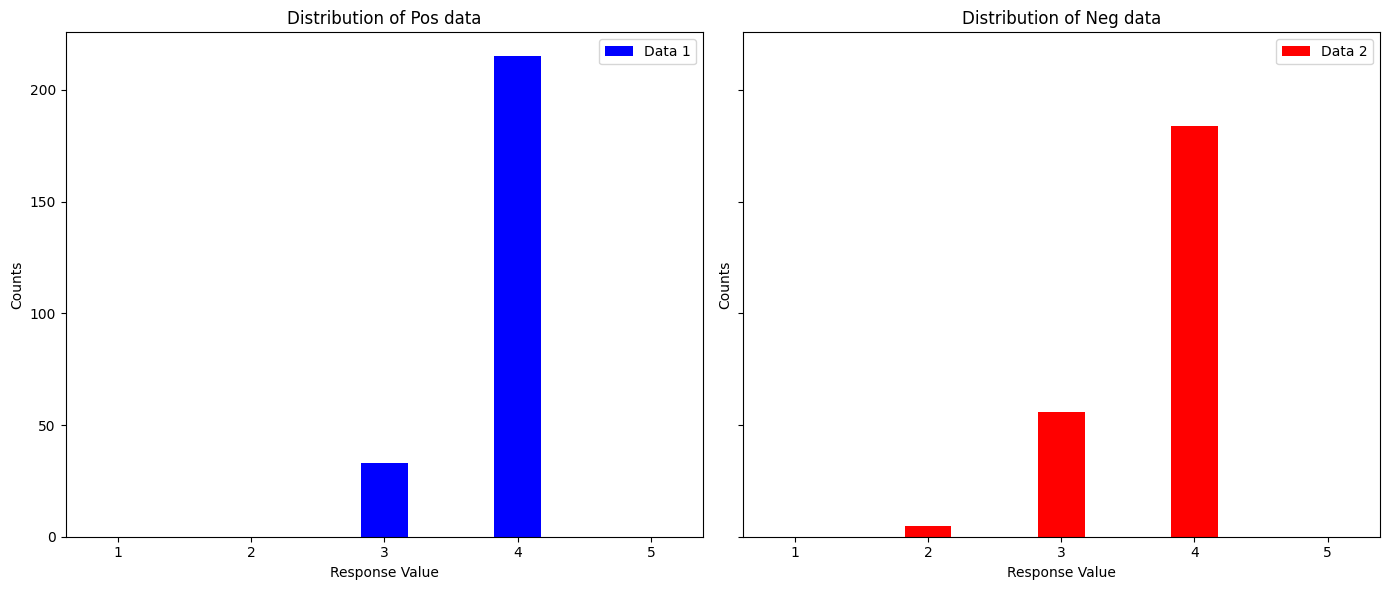

In [ ]:
response_values = sorted(posData.keys(), key=int)
counts1 = [posData[k] for k in response_values]
counts2 = [negData[k] for k in response_values]

# X-axis positions
indices = np.arange(len(response_values))

# Plot width
width = 0.35

# Creating the figure and axes objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)  # Two subplots side by side

# Plotting for Data 1
ax1.bar(indices, counts1, width, color='b', label='Data 1')
ax1.set_xlabel('Response Value')
ax1.set_ylabel('Counts')
ax1.set_title('Distribution of Pos data')
ax1.set_xticks(indices)
ax1.set_xticklabels(response_values)
ax1.legend()

# Plotting for Data 2
ax2.bar(indices, counts2, width, color='r', label='Data 2')
ax2.set_xlabel('Response Value')
ax2.set_ylabel('Counts')
ax2.set_title('Distribution of Neg data')
ax2.set_xticks(indices)
ax2.set_xticklabels(response_values)
ax2.legend()

# Display the plot
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()


In [ ]:
counts2

[0, 0, 0, 2, 1, 26, 156, 56, 0, 0]

In [ ]:
counts1

[0, 0, 0, 1, 0, 9, 137, 95, 1, 0]

In [25]:
true = [str(i) for i in labels]
report = classification_report(y_pred=pred, y_true=true, target_names=["Non-Humorous","Humorous"])


In [26]:
print(resultsData['falsePos'][0]['input'])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are humor classification model, determine whether the target dialogue is humorous. RESTRICTION: ONLY RESPOND 1 (for humorous) OR 0 (for not humorous).<|eot_id|><|start_header_id|>user<|end_header_id|>

Target:
Mrs Wolowitz says "She's a lovely girl! Cute as a button!" to Howard and MrsWolowitz.


Rate the target dialogue on a scale of 1 (not humorous) to 5 (humorous).<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [27]:
print(report)

              precision    recall  f1-score   support

Non-Humorous       0.73      0.08      0.14       250
    Humorous       0.51      0.97      0.67       250

    accuracy                           0.52       500
   macro avg       0.62      0.52      0.40       500
weighted avg       0.62      0.52      0.40       500



# Some interesting outputs along the way:

## user: "**What do you know about the sitcom the Big Bang Theory?**"

A popular and iconic sitcom! The Big Bang Theory is a American sitcom that originally aired from 2007 to 2019. Created by Chuck Lorre and Bill Prady, the show is a comedy about a group of socially awkward and intellectually brilliant scientists and their neighbor, a waitress and aspiring actress.

The show revolves around the lives of five main characters:

1. Sheldon Cooper (played by Jim Parsons), a theoretical physicist with Asperger's syndrome and a strict adherence to routine.
2. Leonard Hofstadter (played by Johnny Galecki), an experimental physicist and Sheldon's roommate and best friend.
3. Howard Wolowitz (played by Simon Helberg), an aerospace engineer and fellow physicist who lives across the hall from Leonard and Sheldon.
4. Rajesh "Raj" Koothrappali (played by Kunal Nayyar), an astrophysicist who is unable to speak in the presence of women unless he drinks alcohol.
5. Penny (played by Kaley Cuoco), a waitress and aspiring actress who lives across the hall from Leonard and Sheldon.

Throughout the show's 12 seasons, the characters navigate their personal and professional lives, often finding themselves in humorous and absurd situations. The show explores themes such as friendship, love, and the [cut off]

-------------------

## Prompt:
system: "You are humor classification model that takes a given line (the target) along with several precending lines (the context), and determines whether the target line was humorous (return '1') or not humorous (return '0'). RESTRICTION: ONLY RESPOND 1 OR 0."

user: 'Is the following target_moment from the sitcom, the Big Bang Theory, humorous or not humorous? Only respond '1' for humorous or '0' for not humorous:

The Scene is still: The Cafeteria
Sheldon says "It's not what it looks like." to Leonard.'

assistant: 'Can you provide some context to help me with this decision?'

user: 'Yes, use the following as context:

The Scene is still: The Cafeteria
Priya says "My brother-- he's got a big crush on Bernadette." to Leonard.
Leonard says "You're moving back to India?" to Priya.
Leonard says "What's going on?" to Raj, Penny, Raj and Howard.
Penny says "It's-It's not what it looks like." to Raj, Leonard, Raj and Howard.Sheldon says "What does it look like?" to Raj, Leonard, Raj and Howard.


## Model's Response:

Based on the context, I would classify the target moment as humorous. The phrase "It's not what it looks like" is a common idiomatic expression, but in this scene, it's being used in a way that's reminiscent of a soap opera or a melodrama, which adds a layer of humor to the situation. The fact that Sheldon is asking "What does it look like?" also implies that he's being obtuse and unaware of the obvious, which is a characteristic that's often played for comedic effect in the show.
